I've never done data scraping before, but this seems really fun! My grandpa collected old baseball cards, so I think that would be a fun thing to look at. There aren't a lot of listings in Charlottesville, so I did listings within 100 miles (and added a location variable to my dataframe).

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup as soup # HTML parser
import requests # Page requests
import re # Regular expressions
import time # Time delays
import random # Random numbers

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sss?postal=22904&purveyor=owner&query=baseball%20cards&search_distance=100#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page


brands = ['topps', 'kellogg','score','fleer','donruss']


bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [48]:
data = []  # We'll save our listings in this object
for k in range(len(listings)):
    # Safely get the title, checking if it exists
    title_tag = listings[k].find('div', class_='title')
    title = title_tag.get_text().lower() if title_tag else 'missing'  # Use 'missing' if title_tag is None

    # Safely get the price, checking if it exists
    price_tag = listings[k].find('div', class_='price')
    price = price_tag.get_text() if price_tag else 'missing'  # Use 'missing' if price_tag is None

    # Safely get the link, checking if href is available
    link_tag = listings[k].find(href=True)
    link = link_tag['href'] if link_tag else 'missing'  # Use 'missing' if link_tag is None

    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands]  # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    # Get years from title string:
    regex_search = re.search(r'(20[0-9]{2}|19[0-9]{2})', title)  # Find year references
    if regex_search is None:  # If no hits, record year as missing value
        year = np.nan
    else:  # If hits, record year as first match
        year = regex_search.group(0)

    # Get location from location string
    location_tag = listings[k].find('div', class_='location')
    location = location_tag.get_text().strip().replace('\n', ' ').lower() if location_tag else 'missing' # use 'missing' if no location tag

    # Append data for the listing
    data.append({'title': title, 'price': price, 'year': year, 'link': link, 'brand': brand, 'location': location})


In [49]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv')
df.head()

(93, 7)


,title,price,year,link,brand,location,age
0,vintage baseball cards,22500.0,NaN,https://washingtondc.craigslist.org/nva/clt/d/...,missing,northern virginia,NaN
1,1950's - 60's vintage baseball cards,1400.0,1950.0,https://washingtondc.craigslist.org/nva/clt/d/...,missing,marshall,75.0
2,35 topps & bowman 2024 baseball rookie cards,20.0,2024.0,https://harrisonburg.craigslist.org/clt/d/grot...,topps,grottoes,1.0
3,29 vintage baseball cards,100.0,NaN,https://washingtondc.craigslist.org/mld/clt/d/...,missing,gaithersburg,NaN
4,baseball cards,20.0,NaN,https://washingtondc.craigslist.org/nva/clt/d/...,missing,warrenton,NaN


Cool! Looks like it's working! Alright, now for some data analysis. First of all, are certain brands generally listed for more money than others?

In [50]:
# Filter out rows where the 'brand' column is 'missing'
df_filtered = df[df['brand'] != 'missing']

# Group by brand and calculate summary statistics for price
price_summary = df_filtered.groupby('brand')['price'].agg(['mean', 'median', 'min', 'max', 'std'])

# Display the summary table
price_summary = price_summary.sort_values(by='mean', ascending=False)  # Optional: Sort by mean price
print(price_summary)


               mean  median   min     max         std
brand                                                
topps    125.851852    20.0   5.0  1095.0  286.291098
fleer     60.000000    60.0  60.0    60.0         NaN
score     55.000000    55.0  55.0    55.0         NaN
donruss   45.500000    45.0   2.0    90.0   37.960506


This is weird data, but I might give it to Donruss, because it might be the only one with more than 1 listing and no crazy outliars as far as I can tell. Speaking of which, it looks like Topps has an outliar. Show yourself!!

In [51]:
# Filter the dataframe for rows where the brand is 'Topps'
topps_df = df[df['brand'].str.lower() == 'topps']

# Find the most expensive listing (row with the maximum price)
most_expensive_topps = topps_df.loc[topps_df['price'].idxmax()]

# Display the most expensive listing's information
print(most_expensive_topps)

title            topps baseball completes sets 1977 1978 1979
price                                                  1095.0
year                                                   1977.0
link        https://washingtondc.craigslist.org/nva/for/d/...
brand                                                   topps
location                                    northern virginia
age                                                      48.0
Name: 26, dtype: object


Alright, looks like that's just a listing for a LOT of baseball cards. Craigslist is a crazy place. Now, I'd like to look at location a little:

<ipython-input-52-7f2d4721bb60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')


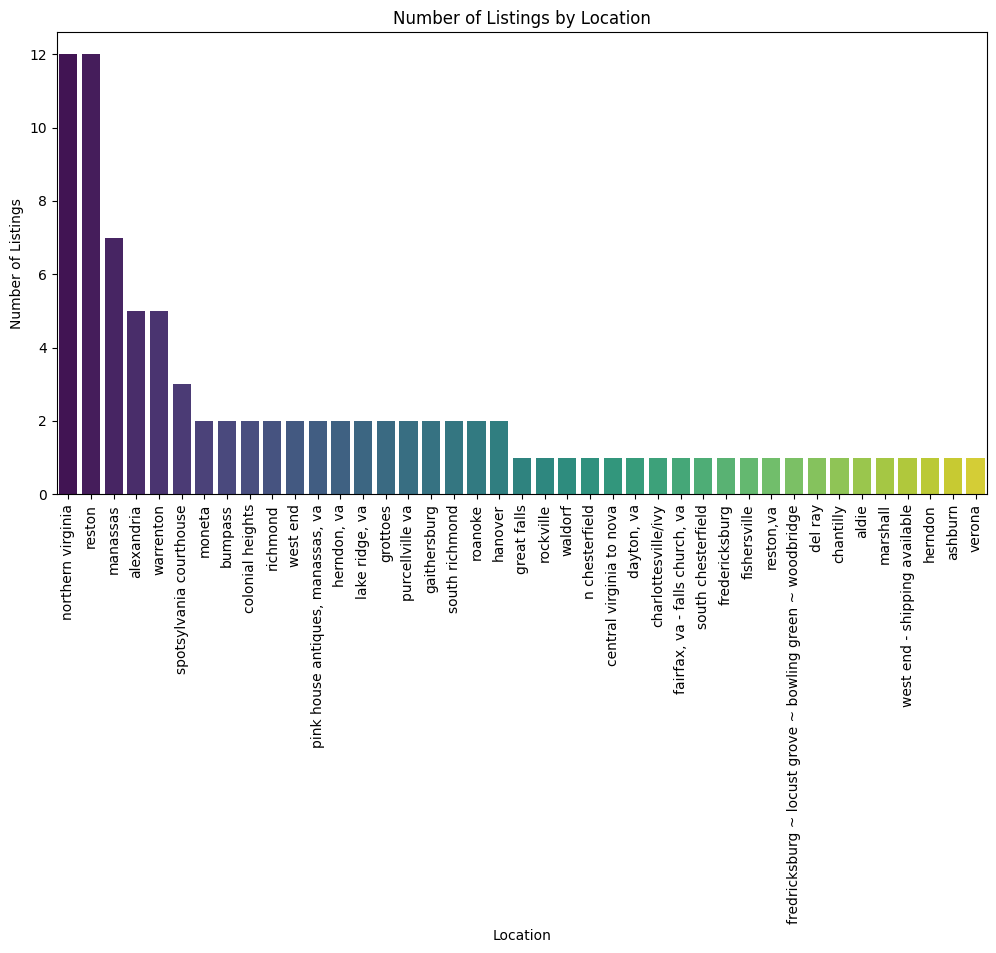

In [52]:
# Count the number of listings per location
location_counts = df['location'].value_counts()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.index, y=location_counts.values, palette='viridis')

# Set plot title and labels
plt.title('Number of Listings by Location')
plt.xlabel('Location')
plt.ylabel('Number of Listings')
plt.xticks(rotation=90)  # Rotate the location labels for better readability
plt.show()

Looks like Nova and Reston have the most collectors (or former collectors; they're selling them)! Finally, I'd like to inspect a theory of mine: people list things on Craigslist with the word 'vintage' because they think it's a buzz word that will make their stuff sell for more. Time to find out! Oh, and this time, let's get rid of some pesky outliars by removing the top listing and all free listings from each category. That's how statisticians do it, right?

In [53]:
# Filter listings with 'vintage' in the title (case insensitive)
vintage_df = df[df['title'].str.contains('vintage', case=False, na=False)]
non_vintage_df = df[~df['title'].str.contains('vintage', case=False, na=False)]

# Remove the top 1 listing (highest price) and all free listings
vintage_filtered_df = vintage_df[~vintage_df['price'].isin(vintage_df.nlargest(1, 'price')['price'])]
vintage_filtered_df = vintage_filtered_df[vintage_filtered_df['price'] != 0]
vintage_filtered_df = vintage_filtered_df[~vintage_filtered_df['title'].str.contains('free', case=False, na=False)]

non_vintage_filtered_df = non_vintage_df[~non_vintage_df['price'].isin(non_vintage_df.nlargest(1, 'price')['price'])]
non_vintage_filtered_df = non_vintage_filtered_df[non_vintage_filtered_df['price'] != 0]
non_vintage_filtered_df = non_vintage_filtered_df[~non_vintage_filtered_df['title'].str.contains('free', case=False, na=False)]

# Calculate summary statistics for the filtered groups
vintage_stats = vintage_filtered_df['price'].agg(['mean', 'median', 'min', 'max', 'std'])
non_vintage_stats = non_vintage_filtered_df['price'].agg(['mean', 'median', 'min', 'max', 'std'])

# Combine the stats into a single DataFrame for comparison
stats_comparison = pd.DataFrame({
    'Vintage Listings': vintage_stats,
    'Non-Vintage Listings': non_vintage_stats
})

# Display the comparison table
print(stats_comparison)


        Vintage Listings  Non-Vintage Listings
mean          750.000000            115.180556
median        750.000000             27.500000
min           100.000000              1.000000
max          1400.000000           1250.000000
std           919.238816            241.311751


I mean, yeah, I guess this would confirm my theory, but I think this data is just bad (I mean, just look at those standard deviations). People list stuff on Craigslist in strange and unhelpful ways and I really don't think I can get valuable data from it with my current skillset. Still a fun thing to do!